In [1]:
import os
import re
import math
import numpy as np
import re
from typing import List, Tuple, Set

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
import nltk
import copy

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import resolve1

from tqdm.notebook import tqdm

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Основные показатели
В качестве основных показателей будем считать width, x0, length. Для каждого элемента формируем confidence_score, как линейную комбинацию значений показателей: width, x0, x1, length.

*bin_confidence* - значение относительной высоты столбика в гистограмме. Чем выше этот столбик - тем больше элементов попадает в эту корзину => больше вероятность, что это полезный текст. Исключение - length, так как по гистограмме видно, что имеем очень много коротких текстов, хотя нам надо отдавать предпочтение более длинным. 

**Итог**:
- Для каждого показателя необходимо подобрать значение веса
- Алгоритм для вычисления bin_confidence
- Алгоритм для вычисления уверенности по длине (нормирование на макс. длину)

### Scores for other attrs (width, x0, x1)

Для каждого аттрибута:
1) Строим его распределение (гистограмма), делим на n бинов \
2) Рассчитываем bin_confidence = кол-во элементов в бине / общее кол-во элементов \
3) attr_confidence рассчитываем, как bin_confidence * attr_weight

## Combine all together

In [4]:
def extract_style(fontname: str) -> Tuple[str, str]:
    STYLES = ['BoldItalic', 'Standart', 'Bold', 'Italic']
    pattern = '|'.join(STYLES)
    
    if not isinstance(fontname, str):
        raise TypeError(f'fontname should be a string, got {type(fontname)} type')
    
    if style_search_res := re.search(pattern, fontname):
        style = style_search_res.group(0)
        font = fontname.split(style)[0]
        # Truncate last symbol because it's dash or comma
        return font[:-1], style
    return fontname, 'Standart'
        

def get_text_format(element) -> Tuple[str, int]:
    """
    Функция итерируется по каждому символу в элементе.
    Для каждого элемента фиксирует шрифт и размер и возвращает самые частовстречающиеся в тексте.
    """
    if not isinstance(element, LTTextContainer):
        raise TypeError('Can only get text format for LTTextContainer elements')
        
    if element.is_empty():
        raise ValueError('Textbox is empty!')
    
    fonts = dict()
    sizes = dict()
    styles = dict()
    
    
    for line in element:
        if isinstance(line, LTTextContainer):
            for character in line:
                if isinstance(character, LTChar) and isinstance(character.fontname, str):
                    character.size = round(character.size)
                    font, style = extract_style(character.fontname)
                    
                    count_font = fonts.get(font, 0)
                    count_style = styles.get(style, 0)
                    count_size = sizes.get(character.size, 0)
                    
                    
                    fonts[font] = count_font + 1
                    sizes[character.size] = count_size + 1
                    styles[style] = count_style + 1

                    
    # Most popular font and size in text
    font = sorted(fonts.items(), key=lambda x: x[1], reverse=True)[0][0] if fonts else 'Other'
    size = sorted(sizes.items(), key=lambda x: x[1], reverse=True)[0][0] if sizes else 0
    style = sorted(styles.items(), key=lambda x: x[1], reverse=True)[0][0] if styles else 'Other'
    return font, size, style


def calculate_len_score(len_value: float, mean_len: float, slopes: Tuple[float, float] = (2, 1.5)):
    def sigmoid(x, slope):
        return 1 / (1 + np.exp(-slope * x))

    slope = slopes[1] if len_value > mean_len else slopes[0]
    normalized_len = (len_value - mean_len) / mean_len
    
    return sigmoid(normalized_len, slope=slope)


def calculate_statistics(pages, verbose=False, verbose_params={}, min_length=50) -> dict:    
    attrs = ['width', 'x0', 'x1', 'font', 'size', 'style', 'length']
    elements = pd.DataFrame(columns=attrs)
    
    for pagenum, page in tqdm(enumerate(pages), total=verbose_params.get("n_pages")):         
        for i, element in enumerate(page._objs):
            if isinstance(element, LTTextContainer) and not element.is_empty():                    
                element.font, element.size, element.style = get_text_format(element)
                element.length = len(element.get_text())
                
                element_data = {attr: getattr(element, attr) for attr in attrs}
                elements.loc[len(elements.index)] = element_data
    
    font, size, style = elements.loc[:, ['font', 'size', 'style']].mode().iloc[0]
    hist_stats = ('hist', 'bin_edges')
    
    statistics = {
        'min_length': min_length,
        'style': style,
        'size': size,
        'font': font,
        'mean_length': elements.length.mean(),
        'width': dict(zip(hist_stats, np.histogram(elements.width))),
        'x0': dict(zip(hist_stats, np.histogram(elements.x0))),
        'x1': dict(zip(hist_stats, np.histogram(elements.x1)))
    }
    
    if verbose:
        print("Most common font:", font)
        print("Most common size:", size)
        print("Most common style:", style)
    
        fig, axs = plt.subplots(3, 2, figsize=(12, 8))
        axs = axs.flatten()
        bins = 20
        
        for i, attr in enumerate(['width', 'x0', 'x1', 'length']):
            ax = axs[i]
            ax.hist(elements[attr], bins=bins, alpha=0.7)
            ax.axvline(elements[attr].mean(), color='red', linestyle='dashed', linewidth=1)
            ax.set_title(attr.capitalize() + ' Distribution')
            ax.set_xlabel(attr.capitalize())
            ax.set_ylabel('Frequency')
            ax.grid(True)        
    
        if verbose and (slopes := (verbose_params.get("len_scores"))):
            ax = axs[4]
            length_scores = elements.length.apply(calculate_len_score, mean_len=elements.length.mean(), slopes=slopes)
        
            sns.scatterplot(x=elements.length, y=length_scores, ax=ax)
            ax.axvline(elements.length.mean(), color='g', linestyle='--', label='Mean Length')
            ax.set_xlabel('Length')
            ax.set_ylabel('Length Score')
            ax.set_title('Length Scores Distribution')
        
        plt.tight_layout()
        plt.show()
        
    return statistics

In [5]:
def get_attr_score(value, bin_edges, bin_scores):
    for i, bin_edge in enumerate(bin_edges):
        if bin_edge > value:
            bin_index = i - 1
            break
    else:
        bin_index = -1
    
    return bin_scores[bin_index] / bin_scores.max()


def get_page_num_score(page_num, total_pages, slope=50):
    x = page_num / total_pages
    return 1 / (1 + np.exp(-slope * (0.5 - abs(0.5 - x))))


def calculate_confidence(scores: dict, weights: dict):
    numerator = sum([score * weights[attr] for attr, score in scores.items()])
    denominator = sum(weights.values())
    
    return numerator / denominator


def get_semantic_scores(text: str, lang='eng'):
    result = {
        'regex': 0,
        'regex_msg': '',
        'verbs': 0
    }
    
    def validate_with_regex(text: str) -> Tuple[bool, str]:
        if re.match(r'(?:\d{1,2}\.\d{1,2})', text):
            return False, 'START_WITH_NUMBERS'
            
        if re.search(r'(?:. ){5,}', text, flags=re.DOTALL):
            return False, 'REPEATED_SEQUENCE'
        
        if (start_with_num_rows := re.findall(r'^\d\.?.*?$', text)) and (len(start_with_num_rows) > 2):
            return False, 'START_WITH_NUM_ROWS'
        return True, 'SUCCESS'
    
    # Validate with regex
    is_valid, validation_message = validate_with_regex(text)
    result['regex'] = 0.5 if is_valid else 0
    result['regex_msg'] = validation_message
    
    # Count verbs in text
    if lang == 'eng':
        verbs_tag = 'VB'
    elif lang in ('rus', 'ru'):
        lang = 'rus'
        verbs_tag = 'V'
    else:
        raise Exception('Supports only English and Russian languages')
        
    tokens = nltk.word_tokenize(text.lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text, lang=lang)
    verbs = [tag for tag in tags if tag[1].startswith(verbs_tag)]
    
    result['verbs'] = len(verbs) / len(tags)
    
    # Linebreaks score
    linebreaks = text.count('\n')
    linebreaks_score = (1 - 0.2 * linebreaks) if linebreaks < 5 else 0
    result['linebreaks'] = linebreaks_score
    
    return result

In [11]:
def parse_pdf(filepath: str,
              attr_weights: dict,
              conf_threshold: float,
              statistics: dict=None,
              len_slopes=(2, 1.5),
              lang='eng',
              verbose: bool = False,
              debug: bool = False,
              debug_dir: str = None
             ):
    
    elements_to_include = []

    if debug:
        if not debug_dir:
            raise ValueError('"debug_dir" argument should be passed if debug=True')
            
        debug_filepath = debug_dir + filepath.split('/')[-1].removesuffix('.pdf') + '_CHECK.pdf'
        debug_pdf = canvas.Canvas(debug_filepath, pagesize=A4)
        debug_pdf.setTitle('parsedFile.pdf')
        
    file = open(filepath, 'rb')
    pages = extract_pages(file)
    parser = PDFParser(file)
    document = PDFDocument(parser)
    n_pages = resolve1(document.catalog['Pages'])['Count']
        
    if not statistics:
        print('Statistics dictionary not passed, calculate statistics...')
        verbose_params={
            "n_pages": n_pages,
            "len_scores": len_slopes
        }
        statistics = calculate_statistics(pages=extract_pages(file),
                                          verbose=verbose,
                                          verbose_params=verbose_params
                                         )
        print(f'Statistics calculated.\nResults:\n{statistics}')
        
    min_length = 50
    
    weights_0 = {name: attr_weights[name].pop('total') for name in attr_weights}
    
    for pagenum, page in tqdm(enumerate(pages), total=n_pages):         
        for i, element in enumerate(page._objs):
            if isinstance(element, LTTextContainer) and not element.is_empty():
                element.text = element.get_text()
                element.font, element.size, element.style = get_text_format(element)
                
                scores = {}
                pos_scores = {}
                semantical_scores = {}
                
                if len(element.text) < min_length:
                    confidence = 0
                else:
                    
                    pos_scores['length'] = calculate_len_score(len(element.text),
                                                           mean_len=statistics['mean_length'],
                                                           slopes=len_slopes)
                    pos_scores['pagenum'] = get_page_num_score(page_num=pagenum, total_pages=n_pages)
                    
                    for attr in ('x0', 'x1', 'width'):
                        pos_scores[attr] = get_attr_score(getattr(element, attr),
                                                      bin_edges=statistics[attr]['bin_edges'],
                                                      bin_scores=statistics[attr]['hist'])                    
                    scores['positional'] = calculate_confidence(pos_scores, weights=attr_weights['positional'])
                    
                    semantical_scores = get_semantic_scores(element.text)
                    semantical_scores['verbs'] *= pos_scores['length']
                    
                    regex_msg = semantical_scores.pop('regex_msg')
                    scores['semantical'] = calculate_confidence(semantical_scores, weights=attr_weights['semantical'])
                    
                    confidence = calculate_confidence(scores, weights_0)
                    
                    if confidence > conf_threshold:
                        elements_to_include.append((element.text, confidence))
                    
                color = 'grey' if confidence < conf_threshold else 'green'
                    
                if debug:
                    debug_pdf.setFillColor(color, alpha=0.2)
                    debug_pdf.rect(element.x0, element.y0, element.width, element.height, stroke=True, fill=True)
                    
                    # Текст элемента
                    text = debug_pdf.beginText(element.x0 + 1, element.y1 - element.size + 2)
                    text.setFont("Times-Roman", element.size)
                    text.setFillColor(color)
                    
                    for line in element.text.split('\n'):
                        text.textLine(line)
                    debug_pdf.drawText(text)
                    
                    # Текст справа от элемента с его параметрами
                    attrs_text = debug_pdf.beginText(element.x1, element.y1 - element.size + 2)
                    attrs_text.setFont("Courier", 7)
                    attrs_text.setFillColor(color)
                    attrs_text.textLine(f'Conf: {confidence}')
                    
                    for attr, value in scores.items():
                        attrs_text.textLine(f'{attr.capitalize()} Score: {value:.2f}')
                    
                    attrs_text.setFont("Courier", 5)
                    for attr, value in pos_scores.items():
                        attrs_text.textLine(f'{attr.capitalize()} Score: {value:.2f}')
                    
                    for attr, value in semantical_scores.items():
                        attrs_text.textLine(f'{attr.capitalize()} Score: {value:.2f}')
                        if attr == 'regex' and value < 0.5:
                            attrs_text.textLine(f'Regex message: {regex_msg}')
                    debug_pdf.drawText(attrs_text)
                            
        debug_pdf.showPage()
    if debug:
        debug_pdf.save()
    file.close()
    return elements_to_include

Process file 1 of 8: An Introduction To Information Retrieval.pdf...
Statistics dictionary not passed, calculate statistics...


  0%|          | 0/581 [00:00<?, ?it/s]

Most common font: DYRINA+Palatino-Roman
Most common size: 10
Most common style: Standart


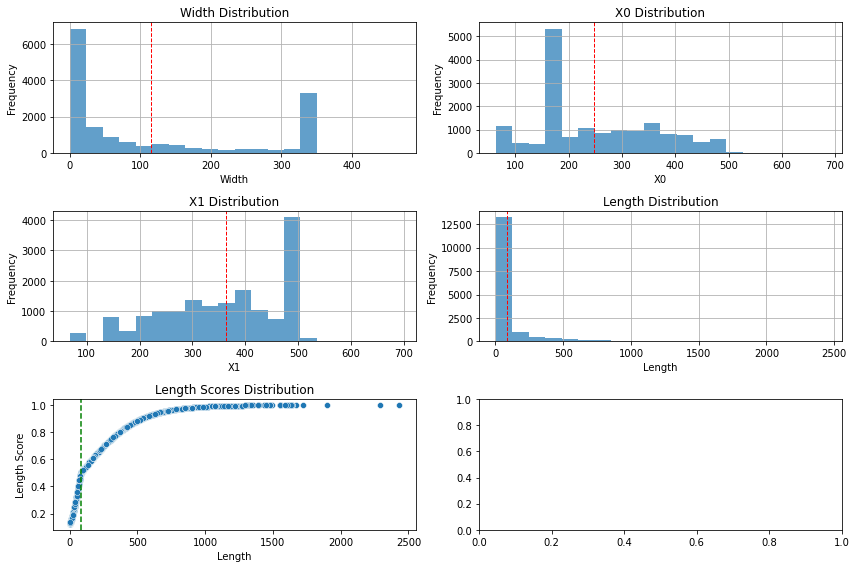

Statistics calculated.
Results:
{'min_length': 50, 'style': 'Standart', 'size': 10, 'font': 'DYRINA+Palatino-Roman', 'mean_length': 81.98043436965744, 'width': {'hist': array([8254, 1499,  873,  687,  405,  391,  336, 3327,   17,    4],
      dtype=int64), 'bin_edges': array([2.22000000e-02, 4.67729540e+01, 9.35237080e+01, 1.40274462e+02,
       1.87025216e+02, 2.33775970e+02, 2.80526724e+02, 3.27277478e+02,
       3.74028232e+02, 4.20778986e+02, 4.67529740e+02])}, 'x0': {'hist': array([1565, 5706, 1716, 1858, 2235, 1581, 1070,   44,    8,   10],
      dtype=int64), 'bin_edges': array([ 63.        , 124.84052791, 186.68105582, 248.52158374,
       310.36211165, 372.20263956, 434.04316747, 495.88369538,
       557.7242233 , 619.56475121, 681.40527912])}, 'x1': {'hist': array([ 284, 1140, 1844, 2364, 2420, 2727, 4854,  135,   14,   11],
      dtype=int64), 'bin_edges': array([ 67.98132   , 130.29248314, 192.60364627, 254.91480941,
       317.22597254, 379.53713568, 441.84829882, 504.1594

  0%|          | 0/581 [00:00<?, ?it/s]

Process file 2 of 8: An Introduction To Information Retrieval_CHECK_CHECK.pdf...
Statistics dictionary not passed, calculate statistics...


  0%|          | 0/581 [00:00<?, ?it/s]

Most common font: Courier
Most common size: 5
Most common style: Standart


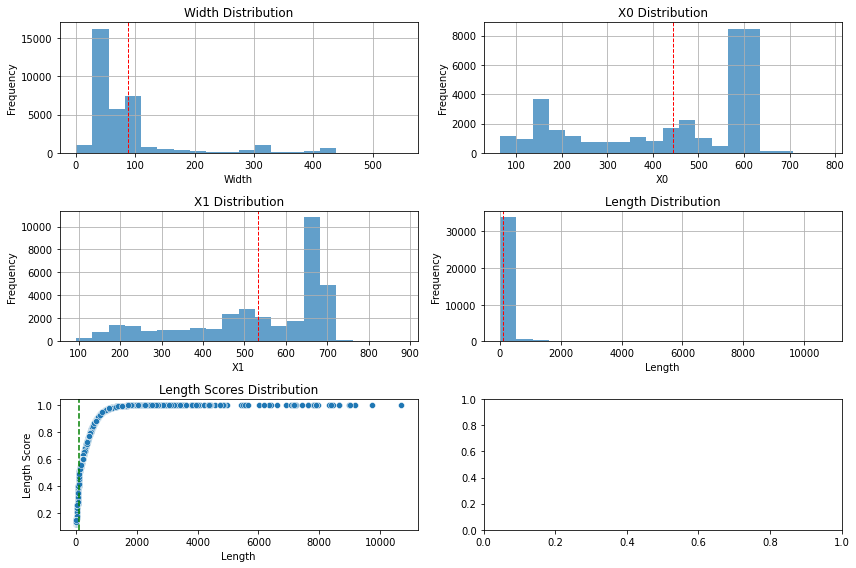

Statistics calculated.
Results:
{'min_length': 50, 'style': 'Standart', 'size': 5, 'font': 'Courier', 'mean_length': 106.2406485201743, 'width': {'hist': array([17220, 13196,  1276,   621,   268,  1460,   268,   948,    67,
          18], dtype=int64), 'bin_edges': array([5.00000e-01, 5.52540e+01, 1.10008e+02, 1.64762e+02, 2.19516e+02,
       2.74270e+02, 3.29024e+02, 3.83778e+02, 4.38532e+02, 4.93286e+02,
       5.48040e+02])}, 'x0': {'hist': array([ 2138,  5285,  1862,  1499,  1921,  3936,  1454, 16909,   313,
          25], dtype=int64), 'bin_edges': array([ 65.     , 136.33955, 207.6791 , 279.01865, 350.3582 , 421.69775,
       493.0373 , 564.37685, 635.7164 , 707.05595, 778.3955 ])}, 'x1': {'hist': array([ 1124,  2746,  1909,  2117,  3441,  5017,  3121, 15729,   115,
          23], dtype=int64), 'bin_edges': array([ 93.196  , 171.79595, 250.3959 , 328.99585, 407.5958 , 486.19575,
       564.7957 , 643.39565, 721.9956 , 800.59555, 879.1955 ])}}


  0%|          | 0/581 [00:00<?, ?it/s]

In [36]:
DATADIR = 'data/raw/text_mining/books/'
PARSED_FILES_DIR = 'data/processed/books/'

filenames = os.listdir(DATADIR)
results = []

weights = {
    "positional": {
        "total": 0.5,    # Вес всех геометрических аргументов
        "length": 0.45,
        "x0": 0.1,
        "x1": 0.15,
        "width": 0.1,
        "pagenum": 0.2,
    },
    "semantical": {
        "total": 0.5,    # Вес всех семантических аргументов
        "regex": 0.4,
        "verbs": 0.3,
        "linebreaks": 0.3 
    }
}

len_slopes = (2, 0.4)


for i, filename in enumerate(filenames[:2]):
    attr_weights = copy.deepcopy(weights)
    print(f'Process file {i + 1} of {len(filenames)}: {filename}...')
    res = parse_pdf(DATADIR + filename,
                    attr_weights=attr_weights,
                    len_slopes=len_slopes,
                    conf_threshold=0.55,
                    verbose=True,
                    debug=True,
                    debug_dir=PARSED_FILES_DIR)
    results.append(res)

In [37]:
texts = [' '.join([text for text, score in result]) for result in results]

In [38]:
texts = list(zip(filenames[:2], texts))

In [39]:
for name, text in texts:
    with open(f'data/processed/texts/{name.removesuffix("pdf") + "txt"}', 'w', errors='ignore') as f:
        f.write(text)